## What does this notebook do?
This notebook accesses data from [space-track.org](https://www.space-track.org/) to plot the debris count by size at each altitude range, along with the number of payloads on a logarithmic scale. The data is a part of space-track's [gp](https://www.space-track.org/documentation#api-basicSpaceDataGp) class ( general perturbations ), which is an efficient listing of the newest SGP4 keplerian element set for each artificial earth-orbiting object tracked by the 18th Space Defense Squadron.

## Requirements:
To use this notebook, replace 'username' and 'password' with your existing login credentials. Uncomment and run the required line below to ensure necessary packages are present locally/ in the cloud.

In [7]:
# %pip install matplotlib numpy pandas requests sgp4

In [8]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sgp4.api import Satrec

In [9]:
username = None
password = None

if not username or not password:
    print("Enter valid credentials")

siteCred = { 'identity': username, 'password': password }

In [10]:
# Error class to handle 'POST' and 'GET' errors
class HandleError(Exception):
    def __init__(self, args):
        Exception.__init__(self, "Exception raised with args {0}".format(args))
        self.args = args

# Function to calculate the altitude
def calculate_altitude(row):  
        objRec = Satrec.twoline2rv(row['TLE_LINE1'], row['TLE_LINE2'])
        objPos = objRec.sgp4(row['JULIAN_DATE'], row['FRACTION'])[1]
        satAlt = np.sqrt(objPos[0]**2 + objPos[1]**2 + objPos[2]**2) - 6371
        return satAlt

In [11]:
uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestQuery = "/basicspacedata/query"

# OBJECT_TYPE = DEBRIS
objectDebris = "/class/gp/OBJECT_TYPE/DEBRIS"

# OBJECT_TYPE = PAYLOAD
satPayload = "/class/gp/OBJECT_TYPE/PAYLOAD"

# Filters data by RCS_SIZE
predicate1 = "/RCS_SIZE/%3C%3Enull"

# Orders the data by NORAD_CAT_ID
orderBy = "/orderby/NORAD_CAT_ID%20asc"

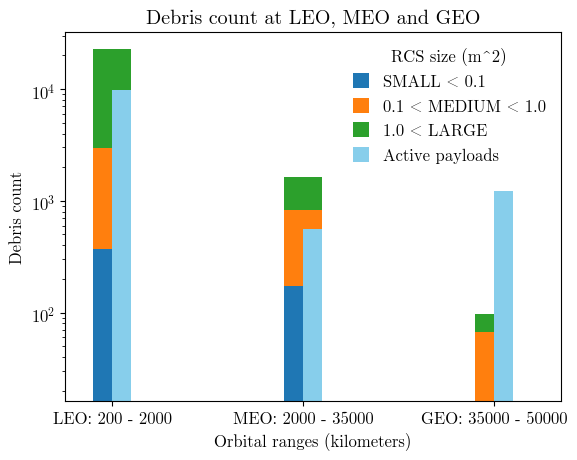

In [12]:
with requests.Session() as session:
    postCheck = session.post(uriBase + requestLogin, data = siteCred)
    if postCheck.status_code != 200:
        raise HandleError('POST')
    
    # Requests for DEBRIS data where RCS_SIZE != null
    response1 = session.get(uriBase + requestQuery + objectDebris + predicate1 + orderBy)
    if response1.status_code != 200:
        raise HandleError('GET')

    # Requests for PAYLOAD data where RCS_SIZE != null
    response2 = session.get(uriBase + requestQuery + satPayload + predicate1 + orderBy)
    if response2.status_code != 200:
        raise HandleError('GET')        
    
    data1 = response1.text
    data2 = response2.text

    dataFrame1 = pd.read_json(io.StringIO(data1))
    dataFrame2 = pd.read_json(io.StringIO(data2))

    """
    Using any available fonts is permissible for the plots, 
    but I chose CMU Serif for aesthetic reasons.
    For Ubuntu, you can install the font package fonts-cmu 
    (using sudo apt install fonts-cmu), which contains the fonts.
    """
    # plt.rcParams['font.family'] = "CMU Serif"
    # plt.rcParams['font.size'] = 12
    
    dataFrame1['EPOCH'] = pd.to_datetime(dataFrame1['EPOCH'])
    dataFrame1['JULIAN_DATE'] = dataFrame1['EPOCH'].apply(lambda x: int(x.to_julian_date()))
    dataFrame1['FRACTION'] = dataFrame1['EPOCH'].apply(lambda x: x.to_julian_date() - int(x.to_julian_date()))
    dataFrame1['ALTITUDE'] = dataFrame1.apply(lambda row: calculate_altitude(row), axis = 1)

    dataFrame2['EPOCH'] = pd.to_datetime(dataFrame2['EPOCH'])
    dataFrame2['JULIAN_DATE'] = dataFrame2['EPOCH'].apply(lambda x: int(x.to_julian_date()))
    dataFrame2['FRACTION'] = dataFrame2['EPOCH'].apply(lambda x: x.to_julian_date() - int(x.to_julian_date()))
    dataFrame2['ALTITUDE'] = dataFrame2.apply(lambda row: calculate_altitude(row), axis = 1)
    
    # Drops the PAYLOAD data where DECAY_DATE != null
    dataFrame2 = dataFrame2[dataFrame2['DECAY_DATE'].isnull()]

    altitudeBins = [200, 2000, 35000, 50000]
    altitudeLabels = ["LEO: 200 - 2000", "MEO: 2000 - 35000", "GEO: 35000 - 50000"]

    sizeLabels = {'SMALL': "SMALL < 0.1", 'MEDIUM': "0.1 < MEDIUM < 1.0", 'LARGE': "1.0 < LARGE"}
    
    dataFrame1['ALTITUDE_BIN'] = pd.cut(dataFrame1['ALTITUDE'], bins = altitudeBins, 
                                        labels = altitudeLabels)
    
    # Plots the debris count at LEO, MEO and GEO
    dataFrame1.groupby(['ALTITUDE_BIN', 'RCS_SIZE'], 
                       observed = False).size().unstack().plot.bar(stacked = True, width = 0.2)

    payloadCount = dataFrame2.groupby(pd.cut(dataFrame2['ALTITUDE'], bins = altitudeBins, 
                                             labels = altitudeLabels), observed = False).size()

    # Plots the payload count at LEO, MEO and GEO
    payloadCount.plot.bar(color = 'skyblue', alpha = 1, position = 0, width = 0.1)
    
    plt.tick_params(rotation = 0)
    
    # Set the yscale to log for a better view
    plt.yscale('log')
    
    plt.xlabel("Orbital ranges (kilometers)")
    plt.ylabel("Debris count")
    plt.title("Debris count at LEO, MEO and GEO")

    legendLabels = [sizeLabels.get(size, size) for size in sorted(dataFrame1['RCS_SIZE'].unique(), 
                                                                  reverse = True)]
    plt.legend(legendLabels + ["Active payloads"], loc = "upper right", title = "RCS size (m^2)",
               ncol = 1, 
               handlelength = 1, 
               handleheight = 1, 
               frameon = False)

session.close()